In [419]:
# load the dataset 

from os import listdir
from matplotlib import image
import cv2 as cv
from sklearn.utils import shuffle

CAR_DIR = "C:/Users/X1/Downloads/DB2C/obj_car"
SHIP_DIR = "C:/Users/X1/Downloads/DB2C/obj_ship"
SIZE = (64,64)
# load all images in a directory
loaded_images = list()
#Load car inages
for filename in listdir(CAR_DIR):
    # load image
    img_data = cv.imread(CAR_DIR+'\\' + filename)
    img_data = cv.resize(img_data,SIZE)
	# store loaded image
    loaded_images.append(("obj_car",img_data))
 
 ############ load ship images
for filename in listdir(SHIP_DIR):
    
	# load image
    img_data = cv.imread(SHIP_DIR+'\\' + filename)
    img_data = cv.resize(img_data,SIZE)
	# store loaded image
    loaded_images.append(("obj_ship",img_data))

#Randomly shuffle the list of images
loaded_images = shuffle(loaded_images)
print(len(loaded_images))


490


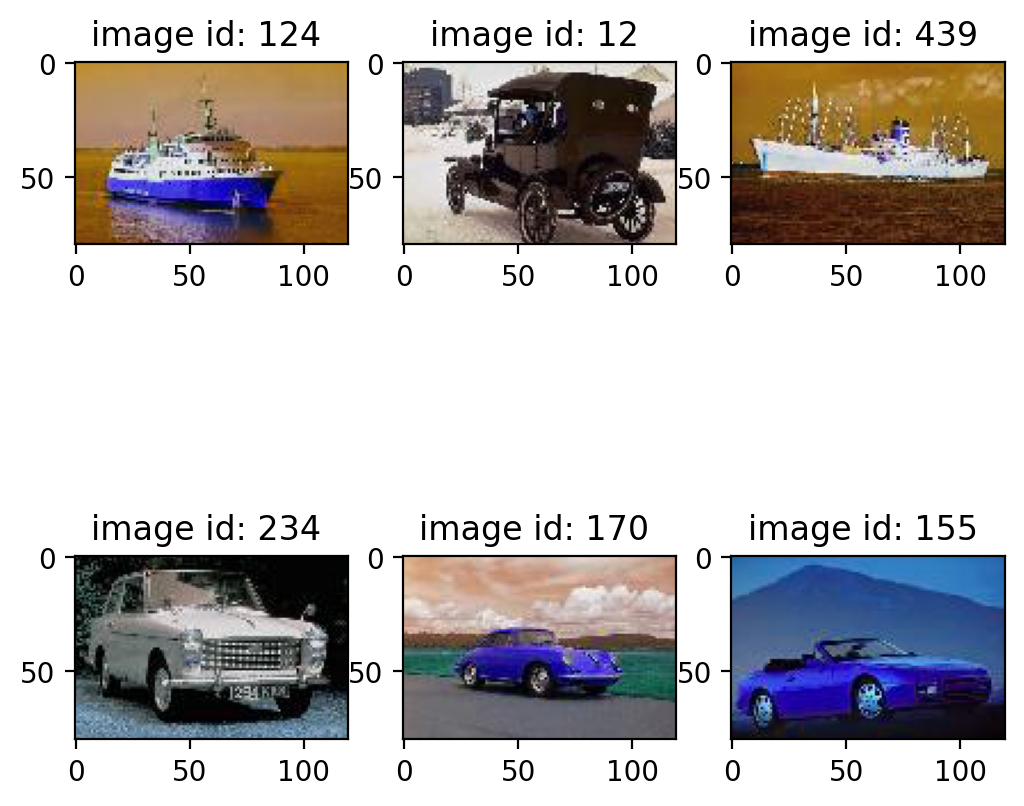

In [420]:
# display random 6 images
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6), dpi=200)
import random
id=random.sample(range(490), 6)
for i in range(6):
    ax1 = fig.add_subplot(2, 3, i+1)
    ax1.imshow(loaded_images[id[i]][1])
    ax1.set_title('image id: %s '% (id[i]))

In [421]:
import cv2 as cv
def hsvHistogramFeatures(image):
   
    rows,cols,dd = image.shape
    # convertir l'image RGB en HSV.
    image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    h = image[...,0]
    s = image[...,1]
    v = image[...,2]

    # Chaque composante h,s,v sera quantifiée équitablement en 8x2x2
    # le nombre de niveau de quantification est:
    numberOfLevelsForH = 8
    numberOfLevelsForS = 2
    numberOfLevelsForV = 2

    # Trouver le maximum.
    maxValueForH = np.max(h)
    maxValueForS = np.max(s)
    maxValueForV = np.max(v)

    # Initialiser l'histogramme à des zéro de dimension 8x2x2
    hsvColorHisto = np.zeros((8,2,2))

    # Quantification de chaque composante en nombre niveaux étlablis
    quantizedValueForH = (h*numberOfLevelsForH/maxValueForH)
    quantizedValueForS = (s*numberOfLevelsForS/maxValueForS)
    quantizedValueForV = (v*numberOfLevelsForV/maxValueForV)

    # Créer un vecteur d'indexes
    index = np.zeros((rows*cols,3))
    index[:,0] = quantizedValueForH.flatten()
    index[:,1] = quantizedValueForS.flatten()
    index[:,2] = quantizedValueForV.flatten()

    # Remplir l'histogramme pour chaque composante h,s,v
    # (ex. si h=7,s=2,v=1 Alors incrémenter de 1 la matrice d'histogramme à la position 7,2,1)
    for i in range(len(index[:,0])):
        if(index[i,0]==0 or index[i,1]==0 or index[i,2]==0):
            continue
        hsvColorHisto[int(index[i,0]),int(index[i,1]),int(index[i,2])] +=1
    # normaliser l'histogramme à la somme
    hsvColorHisto = hsvColorHisto.flatten()
    hsvColorHisto /= np.sum(hsvColorHisto)
    return hsvColorHisto.reshape(-1)

In [422]:
from skimage.feature.texture import greycomatrix , greycoprops
def  textureFeatures(img):
   
    im = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    GLCM = greycomatrix(im, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
    energy = greycoprops(GLCM, 'energy')[0, 0]
    corr = greycoprops(GLCM, 'correlation')[0, 0]
    homogen = greycoprops(GLCM, 'homogeneity')[0, 0]
    contrast = greycoprops(GLCM, 'contrast')[0, 0]
    
    features_texture = np.array([contrast,energy,homogen,corr])
    features_texture /= np.sum(features_texture,axis=0);
    #Il faut normaliser avant de retourner le vecteur descripteur 
    return features_texture.reshape(-1)

In [423]:
#claculating the hog 
from skimage.feature import hog
import numpy as np
def hog_feature(img):
    fd, hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    return hog_feature.reshape(-1)


In [424]:
from mahotas.features import haralick
import cv2 as cv
# bins for histogram
bins = 8

# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    feature = cv.HuMoments(cv.moments(image)).flatten()
    feature /= np.mean(feature)
    return feature.reshape(-1)

# Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralickF = haralick(gray).mean(axis=0)
    # return the result
    return haralickF.reshape(-1)


In [425]:
from mahotas.features import surf
def suf_feature(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    fi = surf.integral(img.copy())
    points = surf.interest_points(fi, 6, 24, 1, max_points=1024, is_integral=True)
    descs = surf.descriptors(fi, points, is_integral=True, descriptor_only=True)
    #spoints = surf.surf(img)
    return descs.reshape(-1)
    

def sift_feature(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create(200)
    kp, des = sift.detectAndCompute(img,None)
    return des.reshape(-1)
    

In [426]:
#empty list for features 
global_features = []
labels = []

def extractAllFeatures():
    for image in loaded_images:
        
        fv_haralick   = fd_haralick(image[1])
        fv_hu_moments = fd_hu_moments(image[1])
        fv_hsvHistograme = hsvHistogramFeatures(image[1])
        fv_texture = textureFeatures(image[1])
        fv_hog = hog_feature(image[1])
        fv_surf = suf_feature(image[1])
        #fv_sift = sift_feature(image[1])
        
        global_feature = np.hstack([fv_hsvHistograme,fv_haralick,fv_hu_moments,fv_texture,fv_hog,fv_surf])
        labels.append(image[0])
        global_features.append(global_feature)
extractAllFeatures()


In [427]:
import os
def extractAllFeaturesToprid(directory):
    
    features = []
    names = []
    files = [os.path.join(directory,p) for p in sorted(os.listdir(directory))]
    
    for f in files:
        
        #read image 
        img = cv.imread(f)
        img = cv.resize(img,SIZE)
        fv_haralick  = fd_haralick(img)
        fv_hu_moments = fd_hu_moments(img)
        fv_hsvHistograme = hsvHistogramFeatures(img)
        fv_texture = textureFeatures(img)
        fv_hog = hog_feature(img)
        fv_surf = suf_feature(img)
        #fv_sift = sift_feature(img)
        
        feature = np.hstack([fv_hsvHistograme,fv_haralick,fv_hu_moments,fv_texture,fv_hog,fv_surf])
        features.append(feature)
        names.append(os.path.basename(f))
    
    return (features ,names)
    

In [428]:
import pandas as pd
dfX = pd.DataFrame(global_features) 
dfY = pd.DataFrame(labels) 


In [429]:
X=dfX.iloc[:,0:-1].values
Y=dfY.iloc[:,-1].values

In [430]:
#from sklearn.preprocessing import Imputer as imp
########################## Standarisation #######################################
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def fillingAndStandarisation(xmat):
    
    im = SimpleImputer(missing_values=np.nan, strategy="mean", fill_value=None, verbose=0, copy=True)
    xmat = im.fit_transform(xmat)
    ssX = StandardScaler()
    xmat = ssX.fit_transform(xmat)
    return xmat

X = fillingAndStandarisation(X)
X.shape
################################## PCA ##########################################
from sklearn.decomposition import PCA
def applyPCA(matt):
    pca = PCA(n_components = 0.95)
    pca.fit(matt)
    matt = pca.transform(matt)
    return matt
    
#X = applyPCA(X)

######################### Split train+test #######################################
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,random_state=2)


In [431]:
X.shape

(490, 9655)

In [432]:
######################## SVM #####################################

from sklearn.svm import SVC
#svclassifier = SVC(kernel='linear') #0.9489795918367347
svclassifier = SVC(kernel='rbf') #0.9591836734693877
#svclassifier = SVC(kernel='poly') #0.8571428571428571
#svclassifier = SVC(kernel='sigmoid') #0.8163265306122449
svclassifier.fit(X_train, y_train) 


y_pred = svclassifier.predict(X_test) 
######################## Evaluating the Algorithm ########################
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("SVM accueacy : ",accuracy_score(y_test,y_pred))

[[85  0]
 [ 5  8]]
              precision    recall  f1-score   support

     obj_car       0.94      1.00      0.97        85
    obj_ship       1.00      0.62      0.76        13

    accuracy                           0.95        98
   macro avg       0.97      0.81      0.87        98
weighted avg       0.95      0.95      0.94        98

SVM accueacy :  0.9489795918367347


In [433]:
######################## KNN #####################################
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train) 

y_pred = svclassifier.predict(X_test) 
######################## Evaluating the Algorithm ########################
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("KNN accueacy : ",accuracy_score(y_test,y_pred))

[[85  0]
 [ 5  8]]
              precision    recall  f1-score   support

     obj_car       0.94      1.00      0.97        85
    obj_ship       1.00      0.62      0.76        13

    accuracy                           0.95        98
   macro avg       0.97      0.81      0.87        98
weighted avg       0.95      0.95      0.94        98

KNN accueacy :  0.9489795918367347


In [434]:
########################### Decision Tree Classifier ############
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

######################## Evaluating the Algorithm ########################
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Decision Tree  accueacy : ",accuracy_score(y_test,y_pred))


[[78  7]
 [ 3 10]]
              precision    recall  f1-score   support

     obj_car       0.96      0.92      0.94        85
    obj_ship       0.59      0.77      0.67        13

    accuracy                           0.90        98
   macro avg       0.78      0.84      0.80        98
weighted avg       0.91      0.90      0.90        98

Decision Tree  accueacy :  0.8979591836734694


In [435]:
############################## voting #############################
from sklearn.ensemble import VotingClassifier

models = list()
models.append(('neigh', KNeighborsClassifier()))
models.append(('clf', DecisionTreeClassifier()))
models.append(('svclassifier', SVC()))

ensemble = VotingClassifier(estimators=models, voting='hard')
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ensemble voting accueacy : ",accuracy_score(y_test,y_pred))



[[85  0]
 [ 4  9]]
              precision    recall  f1-score   support

     obj_car       0.96      1.00      0.98        85
    obj_ship       1.00      0.69      0.82        13

    accuracy                           0.96        98
   macro avg       0.98      0.85      0.90        98
weighted avg       0.96      0.96      0.96        98

ensemble voting accueacy :  0.9591836734693877


In [436]:
features , names = extractAllFeaturesToprid("C:/Users/X1/Downloads/DataToPredict")
features[3].shape

(9656,)

In [437]:
import pandas as pd
dfXtp = pd.DataFrame(features)
dfnames = pd.DataFrame(names)
Xtp=dfXtp.iloc[:,0:-1].values
namesP=dfnames.iloc[:,-1].values

In [438]:
Xtp = fillingAndStandarisation(Xtp)
#Xtp = applyPCA(Xtp)
Xtp.shape


(20, 9655)

In [439]:
######################### ensemble pridection ############
y_predtp = ensemble.predict(Xtp)
y_predtp

array(['obj_car', 'obj_car', 'obj_car', 'obj_car', 'obj_car', 'obj_car',
       'obj_car', 'obj_car', 'obj_car', 'obj_car', 'obj_car', 'obj_ship',
       'obj_ship', 'obj_ship', 'obj_ship', 'obj_ship', 'obj_ship',
       'obj_ship', 'obj_car', 'obj_ship'], dtype=object)

In [441]:
pridctionFrame = pd.DataFrame({"name":names,"class":y_predtp})
pridctionFrame

,name,class
0,29011.jpg,obj_car
1,29013.jpg,obj_car
2,29055.jpg,obj_car
3,354001.jpg,obj_car
4,354053.jpg,obj_car
5,447012.jpg,obj_car
6,447063.jpg,obj_car
7,521022.jpg,obj_car
8,521079.jpg,obj_car
9,521090.jpg,obj_car


In [443]:
pridctionFrame.to_csv("C:/Users/X1/Desktop/master - S3/image-mining/ImageMining/myPrediction.csv",index=False)